In [1]:
import os
import sys
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [3]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import datasets.Datasets
import models.Feedforward
import models.Attention
import models.DannyCNN
import utils.train

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [22]:
# For pixel-to-pixel

# Make datasets and dataloaders

# setup

importlib.reload(datasets.Datasets)

omit_components = 0

batch_size = 256

base_data_path = join_path('Data')

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, 
                (
                    'Autoencoder_Data\\Splits\\List\\'
                    f'reflectance_{split}_list_ae20.pkl'
                ),
            )
            # os.path.join(
            #     base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            # )
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, 
                (
                    'Autoencoder_Data\\Splits\\List\\'
                    f'reflectance_{split}_list_ae20.pkl'
                ),
            )
            # os.path.join(
            #     base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            # )
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path,
                f'Collapsed_Data\\Splits\\List\\temp_{split}_list.pkl',
            )
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path,
                f'Collapsed_Data\\Splits\\List\\temp_{split}_list.pkl',
            )
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path,
                f'Collapsed_Data\\Splits\\List\\elevation_{split}_list.pkl',
            )
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path,
                f'Collapsed_Data\\Splits\\List\\elevation_{split}_list.pkl',
            )
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = datasets.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = datasets.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)

In [5]:
# For CNN

# Make datasets and dataloaders

# setup

importlib.reload(datasets.Datasets)

omit_components = 244 - 32

batch_size = 8

base_data_path = 'Data\\CNN_Data\\Splits'


# load data

emit_train = pickle_load(
    os.path.join(base_data_path, 'reflectance_cnn_train.pkl')
)
emit_val = pickle_load(os.path.join(base_data_path, 'reflectance_cnn_val.pkl'))

elev_train = pickle_load(
    os.path.join(base_data_path, 'elevation_cnn_train.pkl')
)
elev_val = pickle_load(os.path.join(base_data_path, 'elevation_cnn_val.pkl'))

eco_train = pickle_load(os.path.join(base_data_path, 'temp_cnn_train.pkl'))
eco_val = pickle_load(os.path.join(base_data_path, 'temp_cnn_val.pkl'))


# create datasets and dataloaders

train_dataset = datasets.Datasets.CNNDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    y_size=128,
    x_size=128,
)

val_dataset = datasets.Datasets.CNNDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    y_size=128,
    x_size=128,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=None#, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=None#, drop_last=True
)

In [23]:
# For pixel-to-pixel

# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='mean')

model

ToyModel(
  (linear1): Linear(in_features=21, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
  (linear_output): Linear(in_features=8, out_features=1, bias=True)
  (layernorm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
)

In [6]:
# For CNN

# Make model, optimizer, and loss function
importlib.reload(models.DannyCNN)

model = models.DannyCNN.UNet(
    y_size=128, x_size=128, input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='mean')

model

UNet(
  (down1): Conv2d(33, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down5): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down6): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (up6): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), out

In [7]:
importlib.reload(utils.train)

n_epochs = 10

train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    val_loader.dataset.ecostress_scale,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)

RuntimeError: Calculated padded input size per channel: (4 x 4). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

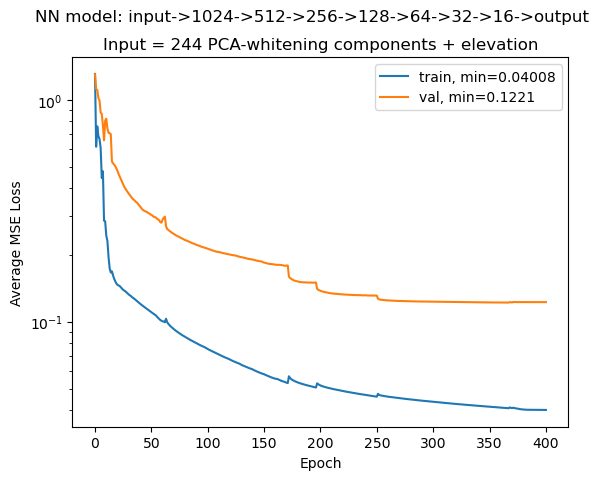

In [8]:
fig, ax = plt.subplots()
fig.suptitle('NN model: input->32->16->8->output')
ax.set_title('Input = 20-dimensional AE embeddings + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=(
        f'train, min_loss={min(train_loss):.4}, '
        f'min_err={train_dataset.ecostress_scale * min(train_loss):.4}'
    ),
)
ax.semilogy(
    np.arange(len(val_loss)),
    val_loss,
    label=(
        f'val, min_loss={min(val_loss):.4}, '
        f'min_err={val_dataset.ecostress_scale * min(val_loss):.4}'
    ),
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 1.1936	 Val Loss: 1.1876 	 Avg Error: 5.4793	LR: 0.0001	Time: 2.3e+01
Epoch 001	 Train Loss: 1.0002	 Val Loss: 0.99749 	 Avg Error: 5.0217	LR: 0.0001	Time: 2.5e+01
Epoch 002	 Train Loss: 1.0116	 Val Loss: 1.0009 	 Avg Error: 5.0301	LR: 0.0001	Time: 2.4e+01
Epoch 003	 Train Loss: 0.98994	 Val Loss: 1.0777 	 Avg Error: 5.2197	LR: 0.0001	Time: 2.4e+01
Epoch 004	 Train Loss: 1.0087	 Val Loss: 1.0035 	 Avg Error: 5.0368	LR: 0.0001	Time: 2.4e+01
Epoch 005	 Train Loss: 1.0038	 Val Loss: 1.0061 	 Avg Error: 5.0433	LR: 5e-05	Time: 2.5e+01
Epoch 006	 Train Loss: 1.0054	 Val Loss: 1.0032 	 Avg Error: 5.0361	LR: 5e-05	Time: 2.5e+01
Epoch 007	 Train Loss: 1.0028	 Val Loss: 1.0035 	 Avg Error: 5.0367	LR: 5e-05	Time: 2.5e+01
Epoch 008	 Train Loss: 0.99963	 Val Loss: 0.99712 	 Avg Error: 5.0207	LR: 2.5e-05	Time: 2.5e+01
Epoch 009	 Train Loss: 0.9957	 Val Loss: 0.99514 	 Avg Error: 5.0158	LR: 2.5e-05	Time: 2.6e+01
Epoch 010	 Train Loss: 0.9933	 Val Loss: 0.99382 	 Avg Error: 5.01

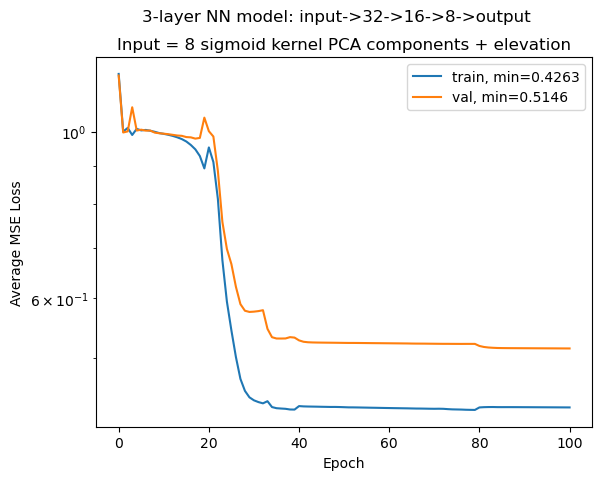

In [6]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 244 - 8

batch_size = 256

base_data_path = (join_path('Data\\Split_Data_2'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(
                # base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            # )
            os.path.join(
                base_data_path, f'KPCA\\Sigmoid\\reflectance_{split}_list.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(
                # base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            # )
            os.path.join(
                base_data_path, f'KPCA\\Sigmoid\\reflectance_{split}_list.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\temp_day_{split}_list.pkl'
            )
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\temp_day_{split}_list.pkl'
            )
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\elevation_{split}_list.pkl'
            )
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\elevation_{split}_list.pkl'
            )
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='mean')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader.dataset.ecostress_scale,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('NN model: input->1024->512->256->128->64->32->16->output')
ax.set_title('Input = 20-dimensional AE embeddings + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)